# w-only PCA
In this file we do PCA on the 2-fluid GDM ($w,c_s^2$) model with $c_s^2(k,\tau)$ held fixed to the fiducial and $w(\tau)$ varied

In [37]:
# third party imports
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import numba
import pickle

# other project files
import par
import modes
import spectra

In [38]:
H0 = 1.0
h = H0/100.
OmegaB0 = 0.04968
OmegaC0 = 0.26754
OmegaG0 = 5.50234e-5
OmegaN0 = 3.74248e-5 

NT = 16384
NK = 256
a0_pca = 0.00005
A = np.linspace(par.a0, par.a_rec, 2*NT)
K = np.linspace(0.01,1000,NK)

# 3 fluid GDM functions
wC = np.zeros(2*NT)
cs2C = np.zeros((2*NT,NK))
wN = np.ones(2*NT)*1/3
cs2N = np.ones((2*NT,NK))*1/3

# solve using 3-fluid
Y = modes.solve_3fld(A, K, wC, cs2C, wN, cs2N,
        OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)


In [39]:
# calculate GDM functions
Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T

OmegaB = OmegaB0 * A[::2]**-3
OmegaC = OmegaC0 * A[::2]**-3
OmegaN = OmegaN0 * A[::2]**-4
OmegaG = OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN/3)/(deltaD*OmegaD)
delta_pD = deltaN

(0, 16000)

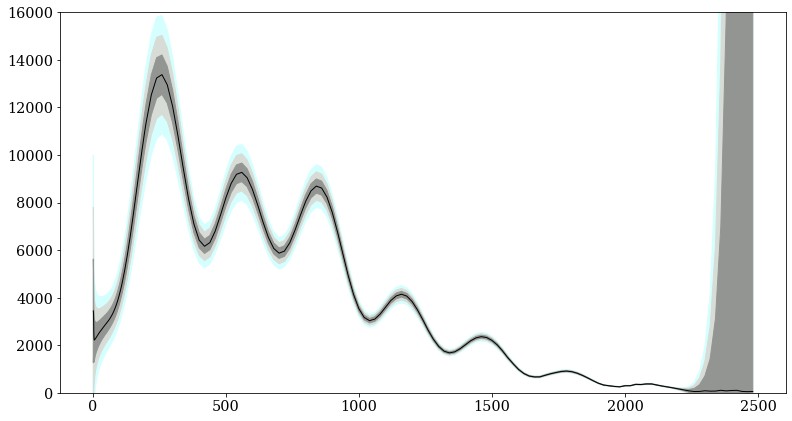

In [40]:
Cl = spectra.get_Cl_2fld(A[::2], K, wD, cs2D, deltaD[:,0], vD[:,0], 
                         OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)

ell = spectra.l_list
f_sky = 1.0  # fraction of sky
l_s = 480.  # filtering scale
theta_pix = 0.0012  # rad
sigma_pix = 16.e-6
wbar = 1/(0.33e-15)
B_cl = np.exp(-ell*(ell + 1)/l_s**2)

err = np.sqrt(
    (2/((2*ell+1)*f_sky)) * (Cl + wbar**(-1) * B_cl**-2)**2
)
Sigma = np.diag(err**2)
#Sigma = np.eye(len(ell))

plt.rcParams.update(par.plot_params)

plt.fill_between(ell,Cl-3*err, Cl+3*err,
                 color='xkcd:very light blue')
plt.fill_between(ell,Cl-2*err, Cl+2*err,
                 color='xkcd:light gray')
plt.fill_between(ell,Cl-err, Cl+err,
                 color='xkcd:gray')
plt.plot(ell,Cl, color='black',linewidth=1)
plt.ylim(0,16000)


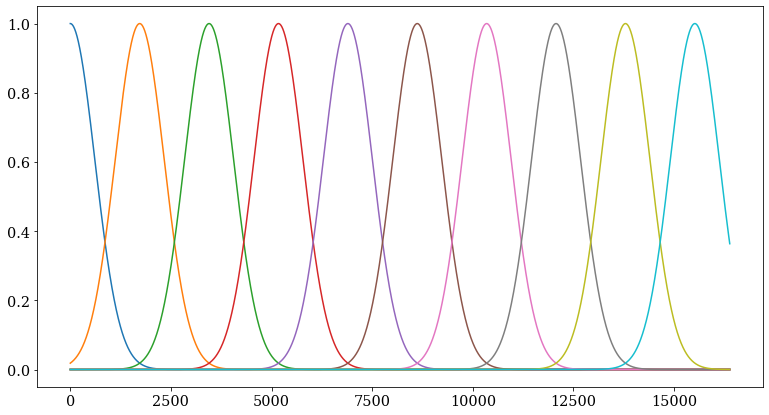

In [41]:
NC = 20
B = np.zeros((NC,NT))
width=NT//(NC-1)
for i in range(NC):
    B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)


plt.plot(B[::2,:].T)
plt.show()

In [42]:
def DO_PCA(q, t):
    NC = 2**q
    
    # initialize a 1-d gaussian basis
    B = np.zeros((NC,NT))
    width=NT//(NC-1)
    for i in range(NC):
        B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)
    B[:, A[::2]<a0_pca]=0
    
    ss = 0.1**t #(derivative step size)
    J = np.zeros((spectra.L, NC))

    print('computing derivatives (t='+str(t)+')')

    for n in range(NC):
        Delta_w = ss*B[n]
        Cl_fwd = spectra.get_Cl_2fld(A[::2], K, wD+Delta_w, cs2D, deltaD[:,0], vD[:,0], 
                                 OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)
        Cl_bwd = spectra.get_Cl_2fld(A[::2], K, wD-Delta_w, cs2D, deltaD[:,0], vD[:,0], 
                                 OmegaB0, OmegaC0, OmegaG0, OmegaN0, H0)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
            
    pickle.dump(J, open("output/w-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (t='+str(t)+')')
    
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/w-only/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (t='+str(t)+')')
    
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, NT))
    for i in range(10):
        PC[i,:] = PV[:,i]@B
    pickle.dump(PC, open("output/w-only/PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/w-only/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (t='+str(t)+')')


In [43]:
for q in range(4, 10):
    for t in range(4,8):
        DO_PCA(q,t)

computing derivatives (t=4)

 derivatives saved (t=4)

 Fisher matrix saved (t=4)

 PCs and SVs saved (t=4)
computing derivatives (t=5)

 derivatives saved (t=5)

 Fisher matrix saved (t=5)

 PCs and SVs saved (t=5)
computing derivatives (t=6)

 derivatives saved (t=6)

 Fisher matrix saved (t=6)

 PCs and SVs saved (t=6)
computing derivatives (t=7)

 derivatives saved (t=7)

 Fisher matrix saved (t=7)

 PCs and SVs saved (t=7)
computing derivatives (t=4)

 derivatives saved (t=4)

 Fisher matrix saved (t=4)

 PCs and SVs saved (t=4)
computing derivatives (t=5)

 derivatives saved (t=5)

 Fisher matrix saved (t=5)

 PCs and SVs saved (t=5)
computing derivatives (t=6)

 derivatives saved (t=6)

 Fisher matrix saved (t=6)

 PCs and SVs saved (t=6)
computing derivatives (t=7)

 derivatives saved (t=7)

 Fisher matrix saved (t=7)

 PCs and SVs saved (t=7)
computing derivatives (t=4)

 derivatives saved (t=4)

 Fisher matrix saved (t=4)

 PCs and SVs saved (t=4)
computing derivatives (t=5)


(6, 10, 16384)


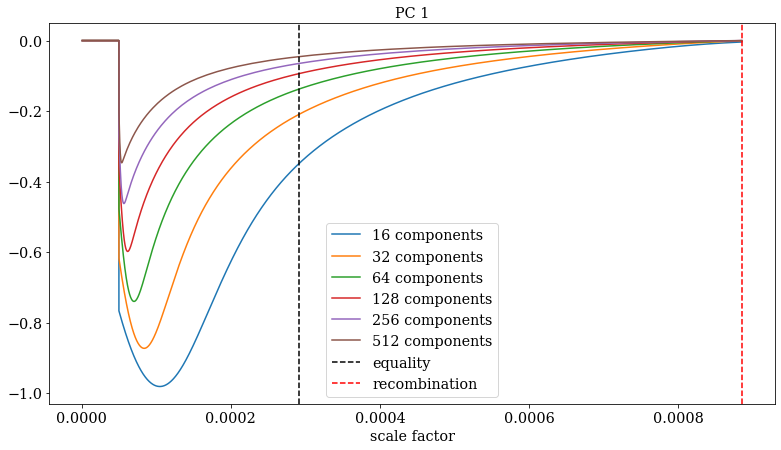

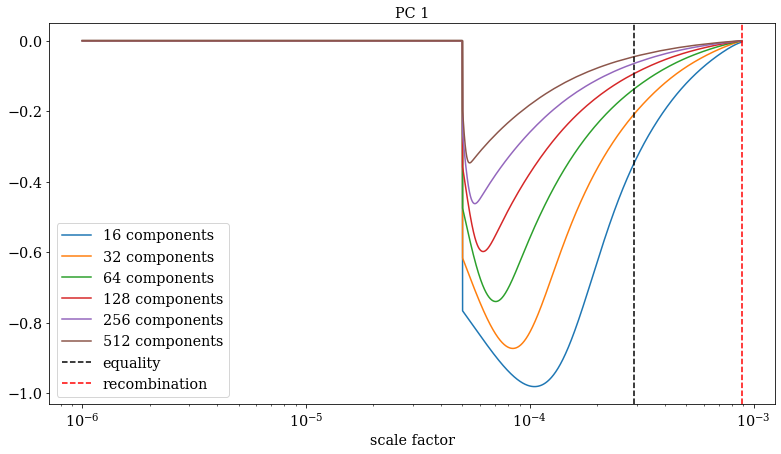

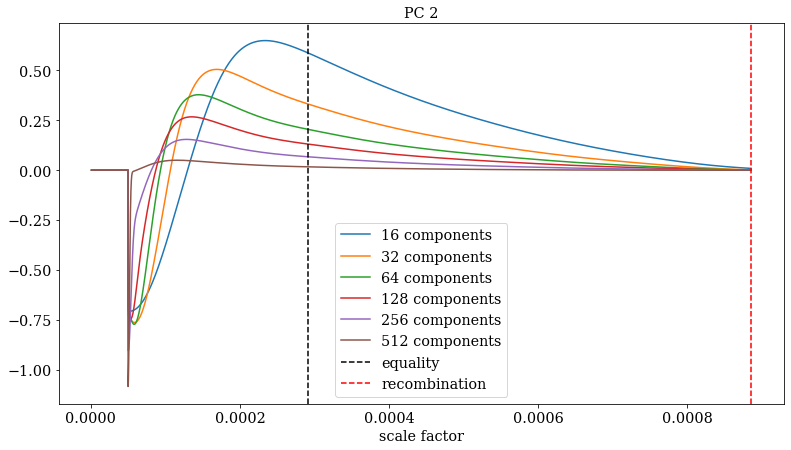

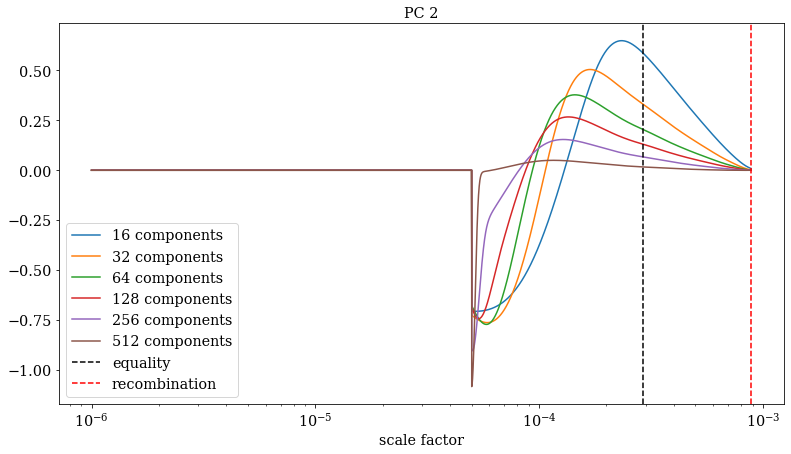

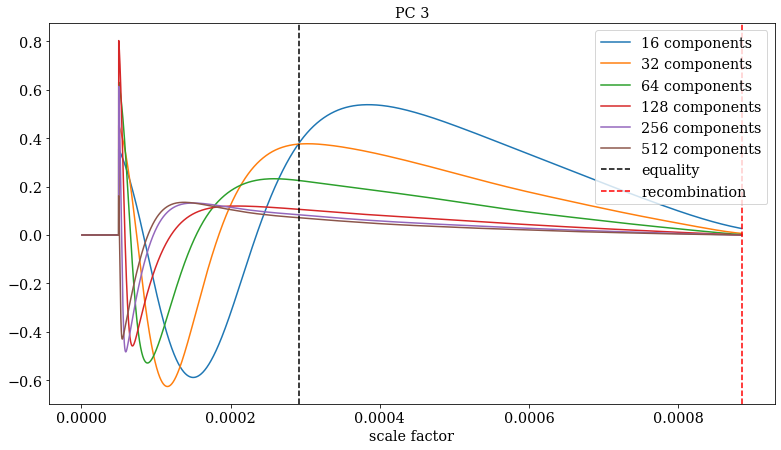

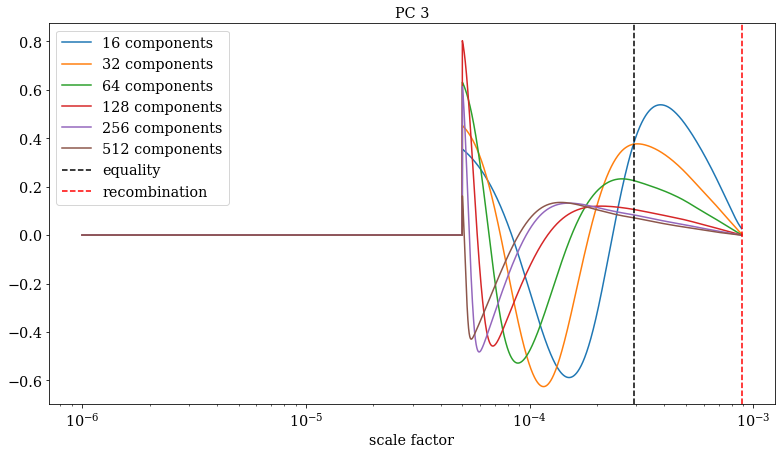

In [80]:
PC_q = np.array(
    [pickle.load(open("output/w-only/PC_q-"+str(q)+"_t-7.p", "rb")) for q in range(4,10)])
#F = pickle.load(open("output/w-only/F_q-4_t-7.p", "rb"))
#infl= np.diag(F)@B
#plt.semilogx(log(infl))
print(np.shape(PC_q))
leg =['16 components','32 components','64 components','128 components','256 components',
           '512 components', 'equality', 'recombination']
plt.title('PC 1')
plt.plot(A[::2],PC_q[:,0].T)
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()
plt.title('PC 1')
plt.semilogx(A[::2],PC_q[:,0].T)
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()

plt.title('PC 2')
plt.plot(A[::2],PC_q[:,1].T)
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()
plt.title('PC 2')
plt.semilogx(A[::2],PC_q[:,1].T)
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()

plt.title('PC 3')
plt.plot(A[::2],PC_q[:2,2,:].T)
plt.plot(A[::2],-PC_q[2:4,2,:].T)
plt.plot(A[::2],PC_q[4,2,:].T)
plt.plot(A[::2],-PC_q[5,2,:].T)
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()
plt.title('PC 3')
plt.plot(A[::2],PC_q[:2,2,:].T)
plt.plot(A[::2],-PC_q[2:4,2,:].T)
plt.plot(A[::2],PC_q[4,2,:].T)
plt.plot(A[::2],-PC_q[5,2,:].T)
plt.semilogx()
plt.axvline(par.a_eq,color = 'black',linestyle='--')
plt.axvline(par.a_rec,color = 'red',linestyle='--')
plt.legend(leg)
plt.xlabel('scale factor')
plt.show()

In [36]:
print(par.tau_now,par.tau_rec)

3.1710305509172256 0.061187443591575685


In [87]:
NC = 2**9
B = np.zeros((NC,NT))
width=NT//(NC-1)
for i in range(NC):
    B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)


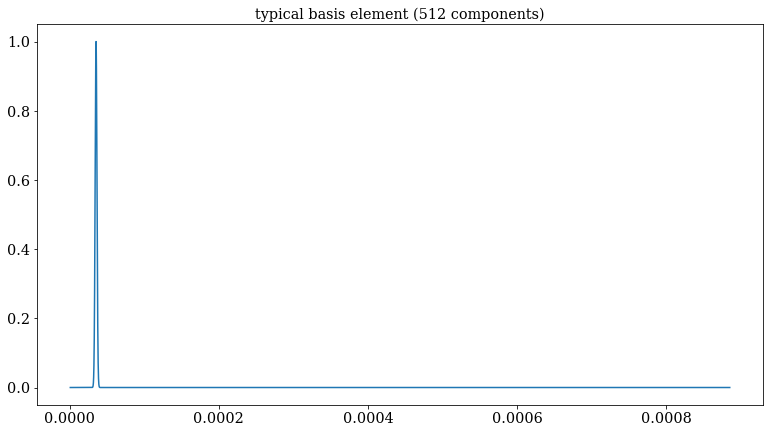

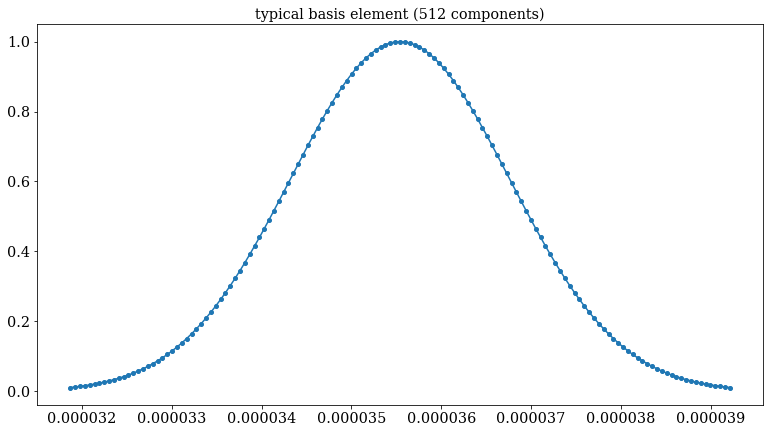

In [115]:
plt.title('typical basis element (512 components)')
plt.plot(A[::2],B[20])
plt.show()
plt.title('typical basis element (512 components)')
plt.plot(A[::2][B[20]>.01],B[20][B[20]>.01],
         marker='.',markersize=8)